In [1]:
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2023-11-23 19:22:07.020310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 19:22:07.542864: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 19:22:08.975392: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hamad/anaconda3/lib/:/home/hamad/anaconda3/lib/python3.10/site-packages/nvidia/cudnn/lib:/home/hamad/anaconda3/lib/:/home/hamad/anaconda3/lib/python3.10/site-packages/nvidia/cudnn/lib:/home/hamad/anaconda3/

Data Loading ( Fused Images )

In [2]:
train_df = pd.read_csv('./train_data_resamples.csv', index_col=-1)
test_df = pd.read_csv('./test_data_resamples.csv', index_col=-1)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['Histology'])

directories_to_search = ['./Fused Lung Train Test/test/Class 0', 
                         './Fused Lung Train Test/test/Class 1',
                         './Fused Lung Train Test/train/Class 0',
                         './Fused Lung Train Test/train/Class 1']


train_filepath = []
valid_filepath = []
test_filepath = []
train_label = []
valid_label = []
test_label = []


for dir in directories_to_search:
    files = os.listdir(dir)
    for file in files:
        if file.endswith('.jpg'):
            
            if file.split('_')[0] in train_df.index:
                train_filepath.append(os.path.join(dir, file))
                train_label.append(train_df.loc[file.split('_')[0], 'Histology'])
            elif file.split('_')[0] in valid_df.index:
                valid_filepath.append(os.path.join(dir, file))
                valid_label.append(valid_df.loc[file.split('_')[0], 'Histology'])
            elif file.split('_')[0] in test_df.index:
                test_filepath.append(os.path.join(dir, file))
                test_label.append(test_df.loc[file.split('_')[0], 'Histology'])
            else:
                print('file not found in any dataframe')



In [3]:
print(f'Filepath example: {train_filepath[:2]}')
print(f'{valid_label[:2]}')

from collections import Counter
print('Training Label Counts:')
print(Counter(train_label))

# check if there are intersections between the train, valid, and test sets

print('Intersections between train and valid:')
print(set(train_df.index).intersection(set(valid_df.index)))
print('Intersections between train and test:')
print(set(train_df.index).intersection(set(test_df.index)))
print('Intersections between valid and test:')
print(set(valid_df.index).intersection(set(test_df.index)))


Filepath example: ['/home/hamad/pttut/project/data/Fused Lung Train Test/test/Class 0/R01-133_73_Fused.jpg', '/home/hamad/pttut/project/data/Fused Lung Train Test/test/Class 0/R01-133_103_Fused.jpg']
[0, 0]
Training Label Counts:
Counter({1: 2152, 0: 1419})
Intersections between train and valid:
set()
Intersections between train and test:
set()
Intersections between valid and test:
set()


In [4]:
def process_path(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

In [12]:
batch_size = 32
image_size = 224
num_classes = 2

train_ds = tf.data.Dataset.from_tensor_slices((train_filepath, train_label)).map(process_path)#.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((valid_filepath, valid_label)).map(process_path)#.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_filepath, test_label)).map(process_path)#.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

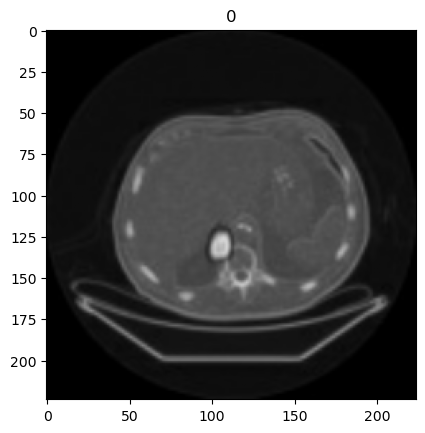

In [16]:
for x, y in train_ds.take(1):
    plt.imshow(x)
    plt.title(y.numpy())
    break

Dataset is ready, Now model building

In [17]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
def create_vgg16_model():
    base_model = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3),
                                             include_top=False,
                                             weights='imagenet')
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [19]:
def create_resnet50_model():
    base_model = tf.keras.applications.ResNet50(input_shape=(image_size, image_size, 3),
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [20]:
def create_inception_model():
    base_model = tf.keras.applications.InceptionV3(input_shape=(image_size, image_size, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [21]:
def create_xception_model():
    base_model = tf.keras.applications.Xception(input_shape=(image_size, image_size, 3),
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [22]:
model = create_vgg16_model()

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy', f1_m, precision_m, recall_m])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 14,846,530
Trainable params: 131,842
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
hist = model.fit(train_ds, epochs=10, validation_data=valid_ds)

# plot the training and validation accuracy and loss at each epoch

plt.figure(figsize=(10, 7))
# plt.plot(hist.history['accuracy'], label='accuracy')
# plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
# plt.plot(hist.history['f1_m'], label='f1_m')
# plt.plot(hist.history['val_f1_m'], label='val_f1_m')
# plt.plot(hist.history['precision_m'], label='precision_m')
# plt.plot(hist.history['val_precision_m'], label='val_precision_m')
# plt.plot(hist.history['recall_m'], label='recall_m')
# plt.plot(hist.history['val_recall_m'], label='val_recall_m')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_ds)

# obtain predictions and plot confusion matrix

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np


ypred = []
ytrue = []

for x, y in test_ds:
    ypred.extend(np.argmax(model.predict(x), axis=1))
    ytrue.extend(y.numpy())

cm = confusion_matrix(ytrue, ypred)
print(classification_report(ytrue, ypred))
ConfusionMatrixDisplay(cm, display_labels=['Class 0', 'Class 1']).plot()

